In [226]:
import polars as pl
hosp_url = 'https://data.cms.gov/sites/default/files/2023-02/26b98405-95dc-46eb-89aa-eb2e3516bc8d/Hospital_Enrollments_2023.02.01.csv'
df = pl.read_csv(hosp_url, encoding = 'latin-1', infer_schema_length = 0, dtypes = {'NPI': int})

In [227]:
df.head()

ENROLLMENT ID,ENROLLMENT STATE,PROVIDER TYPE CODE,PROVIDER TYPE TEXT,NPI,MULTIPLE NPI FLAG,CCN,ASSOCIATE ID,ORGANIZATION NAME,DOING BUSINESS AS NAME,INCORPORATION DATE,INCORPORATION STATE,ORGANIZATION TYPE STRUCTURE,ORGANIZATION OTHER TYPE TEXT,PROPRIETARY_NONPROFIT,ADDRESS LINE 1,ADDRESS LINE 2,CITY,STATE,ZIP CODE,PRACTICE LOCATION TYPE,LOCATION OTHER TYPE TEXT,SUBGROUP - GENERAL,SUBGROUP - ACUTE CARE,SUBGROUP - ALCOHOL DRUG,SUBGROUP - CHILDRENS,SUBGROUP - LONG-TERM,SUBGROUP - PSYCHIATRIC,SUBGROUP - REHABILITATION,SUBGROUP - SHORT-TERM,SUBGROUP - SWING-BED APPROVED,SUBGROUP - PSYCHIATRIC UNIT,SUBGROUP - REHABILITATION UNIT,SUBGROUP - SPECIALTY HOSPITAL,SUBGROUP - OTHER,SUBGROUP - OTHER TEXT
str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""O2002081200001...","""TN""","""00-09""","""PART A PROVIDE...",1467408781,"""N""","""440058""","""5193632180""","""SOUTHERN TENNE...","""SOUTHERN TENNE...","""11/09/1998""","""DE""","""LLC""",null,"""P""","""185 HOSPITAL R...",null,"""WINCHESTER""","""TN""","""373982404""","""OTHER HOSPITAL...",null,"""Y""","""Y""","""N""","""N""","""N""","""N""","""Y""","""N""","""N""","""N""","""N""","""N""","""N""",null
"""O2002081400000...","""ME""","""00-09""","""PART A PROVIDE...",1689653487,"""N""","""200024""","""2567379563""","""CENTRAL MAINE ...",null,"""01/01/1888""","""ME""","""CORPORATION""",null,"""N""","""300 MAIN ST""",null,"""LEWISTON""","""ME""","""042407027""","""MAIN/PRIMARY H...",null,"""Y""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""",null
"""O2002081500002...","""MA""","""00-09""","""PART A PROVIDE...",1134281280,"""N""","""220062""","""8325955347""","""ADCARE HOSPITA...","""ADCARE HOSPITA...","""10/17/1985""","""MA""","""CORPORATION""",null,"""P""","""107 LINCOLN ST...",null,"""WORCESTER""","""MA""","""016052401""","""MAIN/PRIMARY H...",null,"""Y""","""Y""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""",null
"""O2002082100001...","""MA""","""00-09""","""PART A PROVIDE...",1114984671,"""N""","""220012""","""8921915950""","""CAPE COD HOSPI...","""CAPE COD HOSPI...","""08/22/1919""","""MA""","""CORPORATION""",null,"""N""","""27 PARK STREET...","""CAPE COD HOSPI...","""HYANNIS""","""MA""","""026015230""","""OTHER HOSPITAL...",null,"""Y""","""N""","""N""","""N""","""N""","""Y""","""N""","""N""","""N""","""N""","""N""","""N""","""N""",null
"""O2002082600000...","""GA""","""00-09""","""PART A PROVIDE...",1588664007,"""N""","""112011""","""6002723947""","""SELECT SPECIAL...","""SELECT SPECIAL...","""12/05/2001""","""DE""","""CORPORATION""",null,"""P""","""5353 REYNOLDS ...",null,"""SAVANNAH""","""GA""","""314056015""","""MAIN/PRIMARY H...",null,"""N""","""N""","""N""","""N""","""Y""","""N""","""N""","""N""","""N""","""N""","""N""","""N""","""N""",null


In [228]:
cols = [
    'CCN', 
    'ORGANIZATION NAME',
    'DOING BUSINESS AS NAME',
    'ADDRESS LINE 1',
    'CITY',
    'STATE',
    'ZIP CODE',
    'PROPRIETARY_NONPROFIT',
]

rename_dict = {
    'CCN':'hospital_ccn',
    'ORGANIZATION NAME':'org_name',
    'DOING BUSINESS AS NAME':'dba_name',
    'ADDRESS LINE 1':'addr',
    'CITY':'city',
    'STATE':'state',
    'ZIP CODE':'zip',
    'PROPRIETARY_NONPROFIT':'prop_nonprofit',
}

In [229]:
df = df.select(cols).rename(rename_dict).sort('hospital_ccn')

In [230]:
def format_zips() -> pl.Expr:
    # zips go from 123456789 to 12345-6789
    return (pl.col('zip').str.slice(0,5) + '-' + pl.col('zip').str.slice(5)).str.strip('-')

def slice_ccn(n) -> pl.Expr:
    return pl.col('hospital_ccn').str.slice(0,n).alias('sliced_ccn')

def add_singlet(hospital_ccn, values) -> pl.Expr:
    # in case we need to add information about a hospital
    def upd(col, val): 
        return pl.when(pl.col('hospital_ccn') == hospital_ccn).then(val).otherwise(pl.col(col)).alias(col)

    return [upd(k, v) for k,v in values.items()]

In [231]:
# University of Tennessee doesn't have its information in the table
utenn_values = {
    'addr': '1924 ALCOA HIGHWAY',
    'city': 'KNOXVILLE',
    'state': 'TN',
    'zip': '37920',
}

utenn_ccn = '440015'

In [232]:
df = (
    df
    .with_columns([
        # get the first 6 digits of the ccn
        *add_singlet(utenn_ccn,  utenn_values),
        slice_ccn(6),
        format_zips(),
        pl.col('prop_nonprofit').str.to_lowercase()
    ])
    
    # get only the hospitals that don't have extra long CCNs
    .filter(pl.col('hospital_ccn').str.lengths() < 8)
    
    # filter out rehab, psychiatric units, and swing bed hospitals
    # these make up a minority of hospitals, but add confusion to "which" hospital
    # "which"
    .filter(pl.col('sliced_ccn').str.contains('^\d{6}'))

    # some hospitals in a group have CCNs like 12345A, 12345B. they're
    # the same, and we just want one of them.
    # taking the first sliced CCN will get us just one hospital in a group
    .groupby('sliced_ccn')
    .agg(pl.first('*'))
    
    .drop('hospital_ccn')
    .rename({'sliced_ccn':'hospital_ccn'})
    .sort(['state', 'hospital_ccn'])
    
    .with_columns([
        pl.lit(None).alias('file_url').cast(str),
        pl.lit(None).alias('transparency_url').cast(str),
        pl.lit(None).alias('filename').cast(str),
        pl.lit(None).alias('hospital_ein').cast(str)
    ])
    
    # order the columns nicely
    .select([
        'hospital_ccn',
        'hospital_ein',
        'org_name',
        'dba_name',
        'addr',
        'city',
        'state',
        'zip',
        'prop_nonprofit',
        'filename',
        'file_url',
        'transparency_url',        
    ])

)

In [236]:
!pwd

/Users/alecstein/dolthub/bounties/transparency-in-pricing


In [235]:
df.write_csv('hospitals.csv')

In [233]:
df.head()

hospital_ccn,hospital_ein,org_name,dba_name,addr,city,state,zip,prop_nonprofit,filename,file_url,transparency_url
str,str,str,str,str,str,str,str,str,str,str,str
"""020001""",null,"""PROVIDENCE HEA...","""PROVIDENCE ALA...","""3200 PROVIDENC...","""ANCHORAGE""","""AK""","""99508-4615""","""n""",null,null,null
"""020004""",null,"""PEACEHEALTH""","""KETCHIKAN GENE...","""3100 TONGASS A...","""KETCHIKAN""","""AK""","""99901-5746""","""p""",null,null,null
"""020006""",null,"""MAT SU VALLEY ...","""MAT-SU REGIONA...","""2500 S WOODWOR...","""PALMER""","""AK""","""99645-8984""","""p""",null,null,null
"""020008""",null,"""BARTLETT REGIO...",null,"""3260 HOSPITAL ...","""JUNEAU""","""AK""","""99801-7808""","""n""",null,null,null
"""020012""",null,"""FAIRBANKS MEMO...","""FAIRBANKS MEMO...","""1650 COWLES ST...","""FAIRBANKS""","""AK""","""99701-5907""","""n""",null,null,null


In [234]:
for col in df.columns:
    print(f'{col}: {df[col].str.lengths().max()}')

hospital_ccn: 6
hospital_ein: None
org_name: 70
dba_name: 70
addr: 50
city: 25
state: 2
zip: 10
prop_nonprofit: 1
filename: None
file_url: None
transparency_url: None


Here's the schema:
```
CREATE TABLE hospitals (
    hospital_ccn VARCHAR(6),
    hospital_ein VARCHAR(11),
    org_name VARCHAR(100),
    dba_name VARCHAR(100),
    addr VARCHAR(100),
    city VARCHAR(50),
    state CHAR(2),
    zip VARCHAR(10),
    prop_nonprofit enum('p','n'),
    filename VARCHAR(1000),
    file_url VARCHAR(2048),
    transparency_url VARCHAR(2048),
    PRIMARY KEY (hospital_ccn)
);
```

Some useful info:

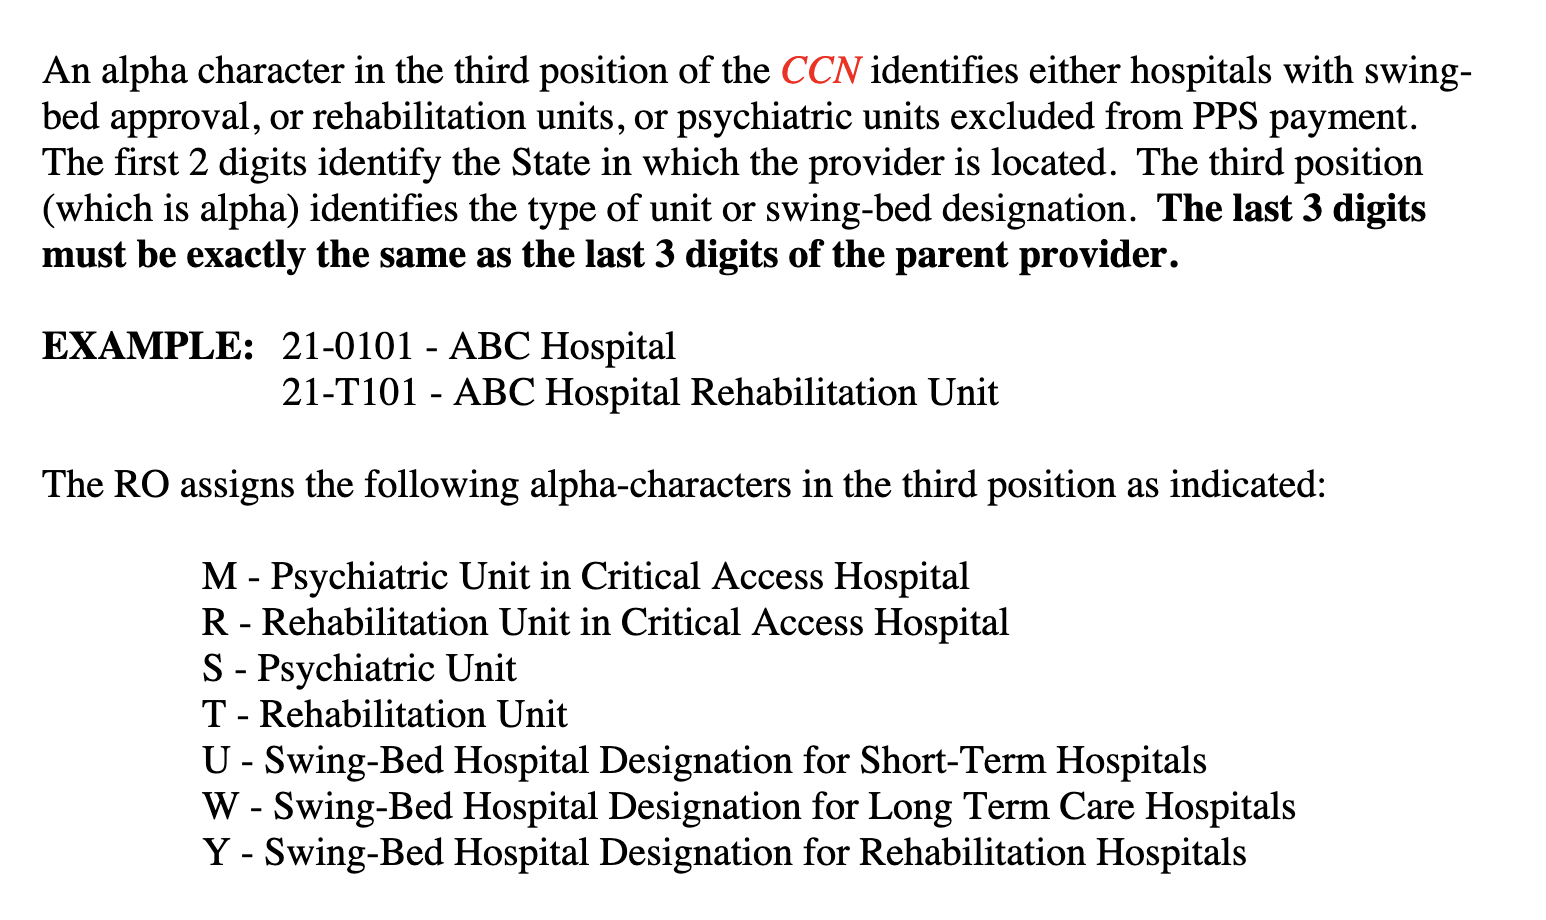